In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from google.colab import files
import random

In [ ]:
uploaded = files.upload()
filename = next(iter(uploaded))

Saving images.jpg to images (1).jpg


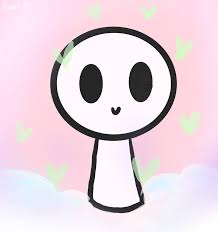

In [ ]:
image = cv2.imread(filename)

if image is not None:
  cv2_imshow(image)
  cv2.waitKey(0)
else:
  print("Failed to load image. Make sure you uploaded a valid PNG file.")

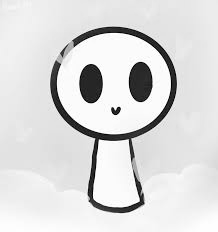

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

## 1st Appraoch: From Scratch

In [ ]:
import numpy as np

def convolution(image, kernel, padding=0, strides=1):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)

    output_height = (image.shape[0] - kernel_height) // strides + 1
    output_width = (image.shape[1] - kernel_width) // strides + 1
    output = np.zeros((output_height, output_width))

    for y in range(0, output_height):
        for x in range(0, output_width):
            region = image[y * strides:y * strides + kernel_height, x * strides:x * strides + kernel_width]
            val = np.sum(region * kernel)
            output[y, x] = val if val > 0 else 0

    return output

def max_pooling(image, pool_size = 2, strides = 1):
    image_height, image_width = image.shape

    output_height = (image_height - pool_size) // strides + 1
    output_width = (image_width - pool_size) // strides + 1
    output = np.zeros((output_height, output_width))

    for y in range(0, output_height):
        for x in range(0, output_width):
            region = image[y * strides:y * strides + pool_size, x * strides:x * strides + pool_size]
            output[y, x] = np.max(region)

    return output

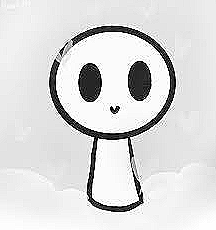

In [ ]:
conv_img = convolution(gray, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
cv2_imshow(conv_img)

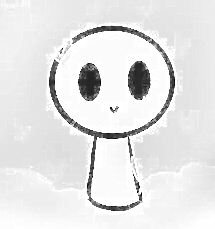

In [ ]:
pool_img = max_pooling(conv_img)
cv2_imshow(pool_img)

In [ ]:
flattned = pool_img.flatten()
weights = np.random.rand(flattned.shape[0])
net = np.dot(flattned, weights)
print(f"The net value is {net}")
out = 1 / (1 + np.exp(-net))
print(f"The output value is {out}")

The net value is 5886033.763426796
The output value is 1.0


## 2nd Approach: With keras

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]).reshape((3, 3, 1, 1))
model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='valid', activation='linear', input_shape=(gray.shape[0], gray.shape[1], 1), use_bias=False))
model.layers[0].set_weights([kernel])

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')

reshaped_img= gray.reshape((1, gray.shape[0], gray.shape[1], 1))

output = model.predict(reshaped_img)

print(f"The output value is {output[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
The output value is 0.0


## 3rd Approach: OpenCV image generation


In [ ]:
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split

IMG_SIZE = 64

def generate_dataset(num_rectangles = 0, num_circles = 0):
    dataset = []
    labels = []
    for i in range(num_rectangles):
        img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        x1 = random.randint(0, IMG_SIZE - 20)
        y1 = random.randint(0, IMG_SIZE - 20)
        x2 = x1 + random.randint(10, 30)
        y2 = y1 + random.randint(10, 30)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255), -1)
        dataset.append(img)
        labels.append(0) # 0 for rectangle
    for i in range(num_circles):
        img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        center_x = random.randint(20, IMG_SIZE - 20)
        center_y = random.randint(20, IMG_SIZE - 20)
        radius = random.randint(10, 20)
        cv2.circle(img, (center_x, center_y), radius, (255, 255), -1)
        dataset.append(img)
        labels.append(1) # 1 for circle

    return np.array(dataset), np.array(labels)

num_rectangles = 100
num_circles = 100
dataset, labels = generate_dataset(num_rectangles, num_circles)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=69)

X_train_gray = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test_gray = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train_gray, y_train, epochs=100, batch_size=32, validation_data = (X_test_gray,y_test))
loss, accuracy = model.evaluate(X_test_gray, y_test, verbose = 0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

def make_predict(img):
    return "Circle" if round(model.predict(img)[0][0]) else "Rectangle"

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5704 - loss: 22.8263 - val_accuracy: 0.7000 - val_loss: 22.9693
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6901 - loss: 17.7777 - val_accuracy: 0.7500 - val_loss: 10.7785
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7753 - loss: 8.1819 - val_accuracy: 0.7250 - val_loss: 8.9462
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8768 - loss: 3.2420 - val_accuracy: 0.8000 - val_loss: 5.8680
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9201 - loss: 1.3820 - val_accuracy: 0.7750 - val_loss: 7.3391
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9093 - loss: 1.0107 - val_accuracy: 0.7500 - val_loss: 4.7640
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9778 - loss: 0.3093 - val_accuracy: 0.7750 - val_loss: 3.5197
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9791 - loss: 0.0995 - val_accuracy: 0.8250 - val_l

In [ ]:
rect = generate_dataset(num_rectangles = 1)
rect = np.array(rect[0]).reshape(1,64,64,1)
print(make_predict(rect))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Rectangle


In [ ]:
cir = generate_dataset(num_circles = 1)
cir = np.array(cir[0]).reshape(1,64,64,1)
print(make_predict(cir))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Circle
